## Download MNIST Dataset

In [4]:
!curl -L -o ./data/mnist.zip\
  https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
!unzip ./data/mnist.zip -d ./data/mnist

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: CRYPT_E_NO_REVOCATION_CHECK (0x80092012) - The revocation function was unable to check revocation for the certificate.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Read MNIST Dataset

In [5]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)    

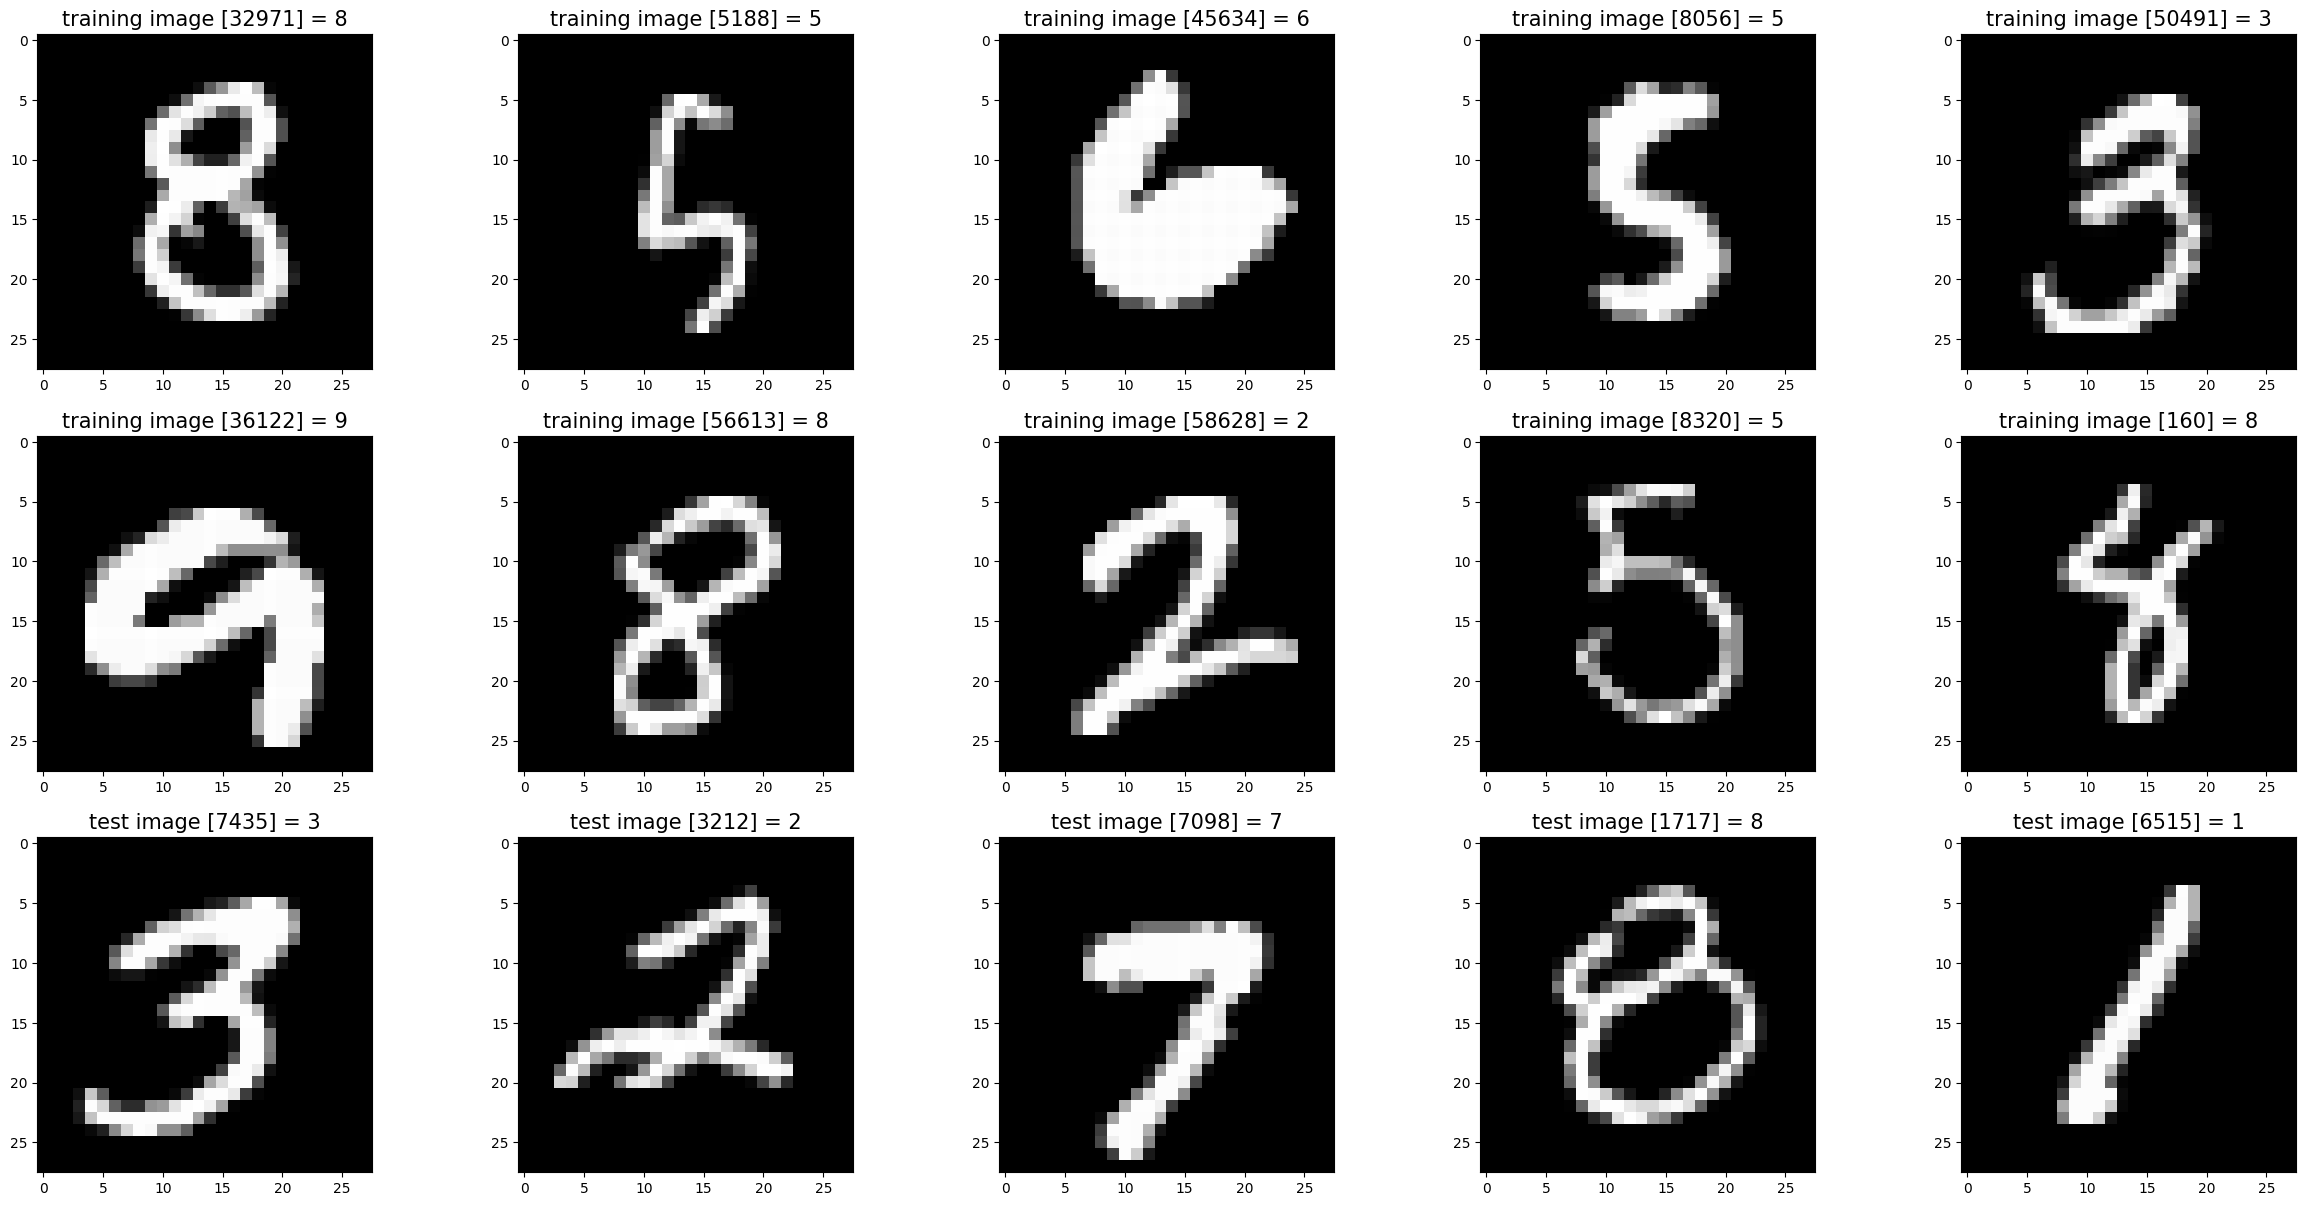

In [6]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
# Use MNIST files already in the workspace root
input_path = r'd:\\artifical-it'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()
    
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## Build Layers

In [7]:
class LinearLayer():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        # He Initialization
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.biases = np.zeros((1, output_size))

    def forward(self, input_data):
        self.input_data = input_data
        return np.dot(input_data, self.weights) + self.biases

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input_data.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)

        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * np.sum(output_gradient, axis=0, keepdims=True)

        return input_gradient
    
class ReLULayer():
    def forward(self, input_data):
        self.input_data = input_data
        return np.maximum(0, input_data)

    def backward(self, output_gradient, learning_rate):
        input_gradient = output_gradient.copy()
        input_gradient[self.input_data <= 0] = 0
        return input_gradient
    
class SoftmaxLayer():
    def forward(self, input_data):
        exps = np.exp(input_data)
        self.output_data = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output_data

    def backward(self, output_gradient, learning_rate):
        return output_gradient  # Gradient is passed through for cross-entropy loss
    
class CrossEntropyLoss():
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        m = targets.shape[0]
        log_likelihood = -np.log(predictions[range(m), targets])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self):
        # self.targets = [0, 1, 2, ..., 9] for each sample
        # self.predictions = softmax outputs, shape (m, 10)
        # Y^ - Y
        # self.predictions[0] = [0.1, 0.2, 0.7] for sample [0, 0, 1]
        # [0, 0, 1] -> [2]
        m = self.targets.shape[0]
        grad = self.predictions.copy()
        one_hot_targets = np.zeros_like(self.predictions)
        one_hot_targets[np.arange(m), self.targets] = 1
        grad -= one_hot_targets
        grad /= m
        return grad
        

## Build Model

In [8]:
class NeuralNetwork():
    def __init__(self):
        self.W1 = LinearLayer(784, 10)
        self.activation1 = ReLULayer()
        self.W2 = LinearLayer(10, 10)
        self.softmax = SoftmaxLayer()
        self.activation2 = ReLULayer()
        self.loss_function = CrossEntropyLoss()

    def forward(self, x):
        out = self.W1.forward(x)
        out = self.activation1.forward(out)
        out = self.W2.forward(out)
        out = self.activation2.forward(out)
        out = self.softmax.forward(out)
        return out

    def backward(self, loss_grad, learning_rate):
        grad = self.softmax.backward(loss_grad, learning_rate)
        grad = self.activation2.backward(grad, learning_rate)
        grad = self.W2.backward(grad, learning_rate)
        grad = self.activation1.backward(grad, learning_rate)
        grad = self.W1.backward(grad, learning_rate)

## Training Loop

In [9]:
np.random.seed(41)

# Initialize and Train
nn = NeuralNetwork()
learning_rate = 0.1
num_epochs = 20
batch_size = 64

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train_normalized = np.array(x_train) / 255.0
x_train_flat = x_train_normalized.reshape(x_train_normalized.shape[0], -1)
y_train_array = np.array(y_train)

m = x_train_flat.shape[0]

losses = []
accuracies = []

for epoch in range(num_epochs):
    indices = np.arange(m)
    np.random.shuffle(indices)
    x_shuffled = x_train_flat[indices]
    y_shuffled = y_train_array[indices]
    
    epoch_loss = 0
    
    for i in range(0, m, batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        
        predictions = nn.forward(x_batch)
        loss = nn.loss_function.forward(predictions, y_batch)
        epoch_loss += loss
        
        loss_grad = nn.loss_function.backward()
        nn.backward(loss_grad, learning_rate)
        
    # Calculate accuracy
    full_preds = nn.forward(x_train_flat)
    predicted_classes = np.argmax(full_preds, axis=1)
    accuracy = np.mean(predicted_classes == y_train_array)
    
    avg_loss = epoch_loss / (m / batch_size)

    losses.append(avg_loss)
    accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1/20, Avg Loss: 0.5121, Accuracy: 90.31%
Epoch 2/20, Avg Loss: 0.3048, Accuracy: 92.19%
Epoch 2/20, Avg Loss: 0.3048, Accuracy: 92.19%
Epoch 3/20, Avg Loss: 0.2771, Accuracy: 92.71%
Epoch 3/20, Avg Loss: 0.2771, Accuracy: 92.71%
Epoch 4/20, Avg Loss: 0.2614, Accuracy: 93.29%
Epoch 4/20, Avg Loss: 0.2614, Accuracy: 93.29%
Epoch 5/20, Avg Loss: 0.2483, Accuracy: 93.23%
Epoch 5/20, Avg Loss: 0.2483, Accuracy: 93.23%
Epoch 6/20, Avg Loss: 0.2411, Accuracy: 93.61%
Epoch 6/20, Avg Loss: 0.2411, Accuracy: 93.61%
Epoch 7/20, Avg Loss: 0.2329, Accuracy: 92.96%
Epoch 7/20, Avg Loss: 0.2329, Accuracy: 92.96%
Epoch 8/20, Avg Loss: 0.2266, Accuracy: 93.69%
Epoch 8/20, Avg Loss: 0.2266, Accuracy: 93.69%
Epoch 9/20, Avg Loss: 0.2223, Accuracy: 93.87%
Epoch 9/20, Avg Loss: 0.2223, Accuracy: 93.87%
Epoch 10/20, Avg Loss: 0.2177, Accuracy: 93.94%
Epoch 10/20, Avg Loss: 0.2177, Accuracy: 93.94%
Epoch 11/20, Avg Loss: 0.2134, Accuracy: 93.54%
Epoch 11/20, Avg Loss: 0.2134, Accuracy: 93.54%
Epoch 12/

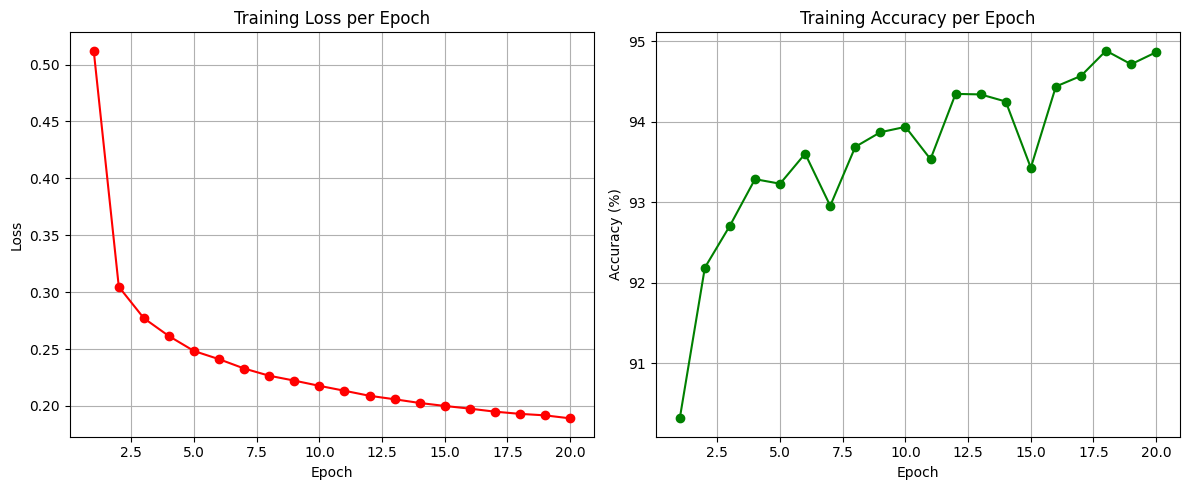

In [10]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, marker='o', color='red')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [a * 100 for a in accuracies], marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
x_test = np.array(x_test) / 255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1)
y_test_array = np.array(y_test)

# Predict on test set
test_preds = nn.forward(x_test_flat)
predicted_labels = np.argmax(test_preds, axis=1)

# Calculate accuracy
test_accuracy = np.mean(predicted_labels == y_test_array)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")

✅ Test Accuracy: 94.19%


🔎 Total misclassified samples: 581


C:\Users\omerg\AppData\Local\Temp\ipykernel_23216\3838106479.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\omerg\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


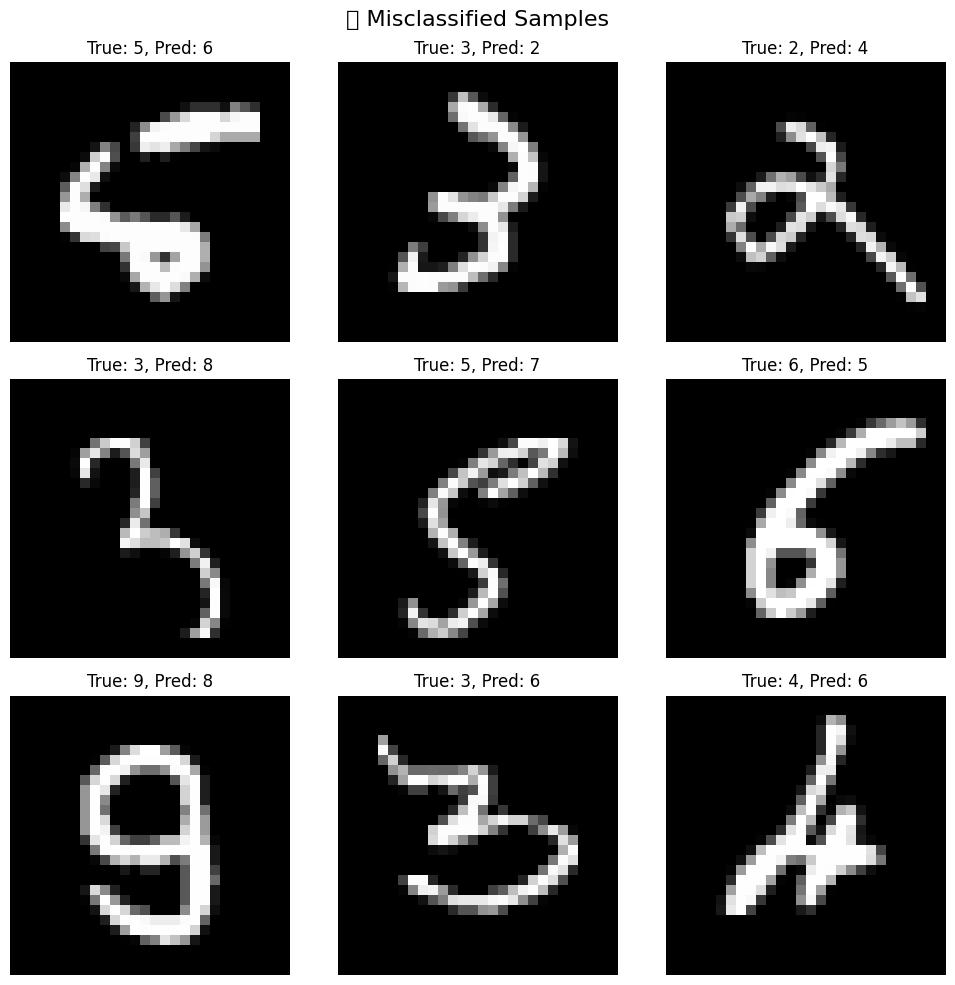

In [12]:
misclassified_indices = np.where(predicted_labels != y_test_array)[0]
print(f"🔎 Total misclassified samples: {len(misclassified_indices)}")

import matplotlib.pyplot as plt

# Choose first 9 misclassified samples
num_to_show = 9
indices_to_show = misclassified_indices[:num_to_show]

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices_to_show):
    img = x_test[idx]
    true_label = y_test_array[idx]
    pred_label = predicted_labels[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.suptitle("❌ Misclassified Samples", fontsize=16)
plt.tight_layout()
plt.show()